In [3]:
import MDAnalysis as mda
import MDAnalysisData

yiip = MDAnalysisData.yiip_equilibrium.fetch_yiip_equilibrium_short()
# NOTE: change this to five before doing true benchmark test
u = mda.Universe(yiip.topology, 1 * [yiip.trajectory], in_memory=True)
positions = u.trajectory.get_array()


/home/law/anaconda3/envs/zarrtraj/lib/python3.10/site-packages/MDAnalysisData/base.py:34: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_string
/home/law/anaconda3/envs/zarrtraj/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:348: UserWarning: Unknown element Z found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/home/law/anaconda3/envs/zarrtraj/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:348: UserWarning: Unknown element D found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/home/law/anaconda3/envs/zarrtraj/lib/python3.10/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D

In [31]:
import numpy as np
import zarr
import h5py
import numcodecs

zarr_compressors = ['zstd', 'blosclz', 'lz4', 'lz4hc', 'zlib']
hdf5_compressors = ['gzip']

# Load yiip data into minimal zarr file and hdf5 files of different compressors
# and compressor levels
def create_zarr_traj(compression, compression_opts):
    root = zarr.open(f'zarrfiles/yiip_{compression}_{compression_opts}_zarr.zarr', mode='w')
    compressor = numcodecs.Blosc(cname=compression, clevel=compression_opts)
    root.create_dataset('positions', data=positions, 
                        chunks = (1, np.shape(positions)[1], 3), 
                        compressor=compressor)


def create_hdf5_traj(compression, compression_opts):
    with h5py.File(f'h5files/yiip_{compression}_{compression_opts}_hdf5.h5', 'w') as root:
        root.create_dataset('positions', data=positions, 
                            chunks = (1, np.shape(positions)[1], 3), 
                            compression=compression, compression_opts=compression_opts)


for c in zarr_compressors:
    for i in range(10):
        create_zarr_traj(c, i)



for c in hdf5_compressors:
    for i in range(10):
        create_hdf5_traj(c, i)



In [34]:
import subprocess
import time

def filesize(filename):
    return int(subprocess.check_output(['du','-s', filename]).split()[0].decode('utf-8'))

def zarr_iteration_time(filename):
    start_time = time.time()
    root = zarr.open(filename, mode='a')
    pos_vals = root['positions']
    num = 0
    for i in range(len(pos_vals)):
        # arbitrary task that requires accessing third dimension
        num += pos_vals[i][0][0]
    end_time = time.time()
    return end_time - start_time

def h5_iteration_time(filename):
    start_time = time.time()
    with h5py.File(filename, 'r') as root:
        pos_vals = root['positions']
        num = 0
        for i in range(len(pos_vals)):
            # arbitrary task that requires accessing third dimension
            num += pos_vals[i][0][0]
    end_time = time.time()
    return end_time - start_time

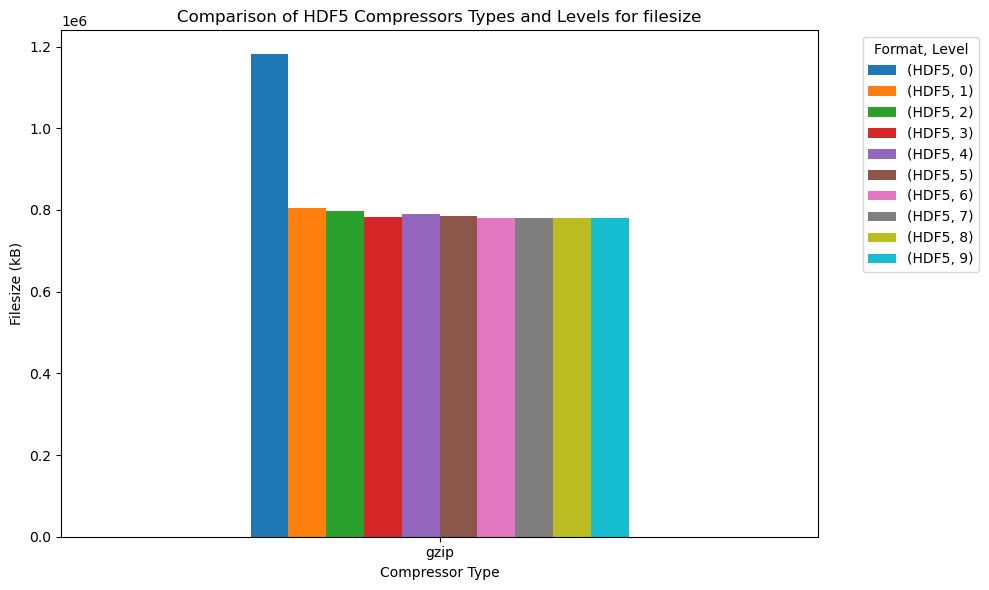

In [33]:
# Plot hdf5 filesize for each compressor and level

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

format = ['HDF5'] * 10 * len(hdf5_compressors)

compressor = [n for n in hdf5_compressors for _ in range(10)]

lvl = list(range(10)) * len(hdf5_compressors)
val = []

for c in hdf5_compressors:
    for i in range(10):
        val.append(filesize(f'yiip_{c}_{i}_hdf5.h5'))


data = {
    'Format': format,
    'Compressor': compressor,
    'Level': lvl,
    'Filesize': val
}

df = pd.DataFrame(data)

pivot_df = df.pivot(index='Compressor', columns=['Format', 'Level'], values='Filesize')

pivot_df.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of HDF5 Compressors Types and Levels for filesize')
plt.xlabel('Compressor Type')
plt.ylabel('Filesize (kB)')
plt.xticks(rotation=0)
plt.legend(title='Format, Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




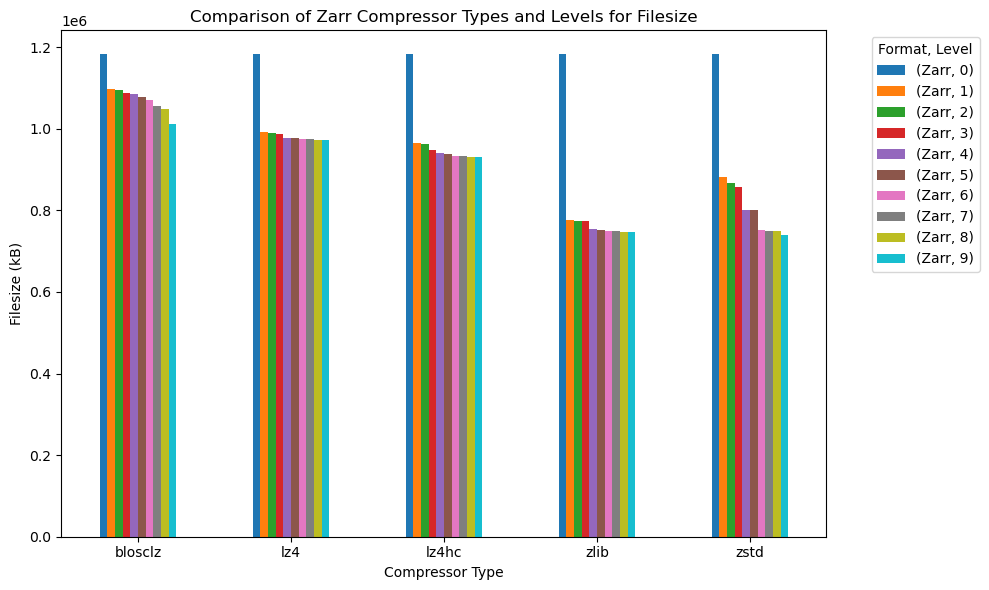

In [ ]:
# Plot zarr filesize for each compressor and level
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


format = ['Zarr'] * 10 * len(zarr_compressors)
compressor = [n for n in zarr_compressors for _ in range(10)]
lvl = list(range(10)) * len(zarr_compressors) 
val = []
for c in zarr_compressors:
    for i in range(10):
        val.append(filesize(f'zarrfiles/yiip_{c}_{i}_zarr.zarr'))

data = {
    'Format': format,
    'Compressor': compressor,
    'Level': lvl,
    'Filesize': val
}

df = pd.DataFrame(data)

pivot_df = df.pivot(index='Compressor', columns=['Format', 'Level'], values='Filesize')

pivot_df.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Zarr Compressor Types and Levels vs Filesize')
plt.xlabel('Compressor Type')
plt.ylabel('Filesize (kB)')
plt.xticks(rotation=0)
plt.legend(title='Format, Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

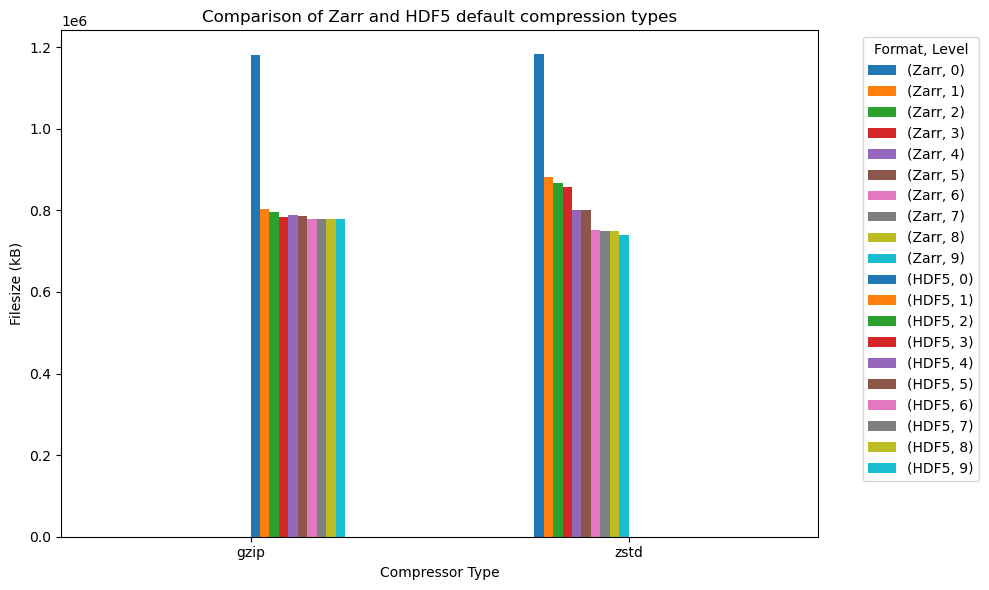

In [45]:
# Plot zarr vs hdf5 for each compressor and level
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


format = ['Zarr'] * 10 
format += ['HDF5'] * 10
compressor = ['zstd'] * 10 + ['gzip'] * 10
lvl = list(range(10)) * 2
val = []

for i in range(10):
    val.append(filesize(f'zarrfiles/yiip_zstd_{i}_zarr.zarr'))
for i in range(10):
    val.append(filesize(f'h5files/yiip_gzip_{i}_hdf5.h5'))

data = {
    'Format': format,
    'Compressor': compressor,
    'Level': lvl,
    'Filesize': val
}

df = pd.DataFrame(data)

pivot_df = df.pivot(index='Compressor', columns=['Format', 'Level'], values='Filesize')

pivot_df.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Zarr and HDF5 default compression types')
plt.xlabel('Compressor Type')
plt.ylabel('Filesize (kB)')
plt.xticks(rotation=0)
plt.legend(title='Format, Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [38]:
# Plot zarr filesize for each compressor and level
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


format = ['Zarr'] * 10 * len(zarr_compressors)
compressor = [n for n in zarr_compressors for _ in range(10)]
lvl = list(range(10)) * len(zarr_compressors) 
val = []
for c in zarr_compressors:
    for i in range(10):
        val.append(zarr_iteration_time(f'zarrfiles/yiip_{c}_{i}_zarr.zarr'))

data = {
    'Format': format,
    'Compressor': compressor,
    'Level': lvl,
    'Filesize': val
}

df = pd.DataFrame(data)

pivot_df = df.pivot(index='Compressor', columns=['Format', 'Level'], values='Filesize')

pivot_df.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Zarr Compressor Types and Levels for Filesize')
plt.xlabel('Compressor Type')
plt.ylabel('Filesize (kB)')
plt.xticks(rotation=0)
plt.legend(title='Format, Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

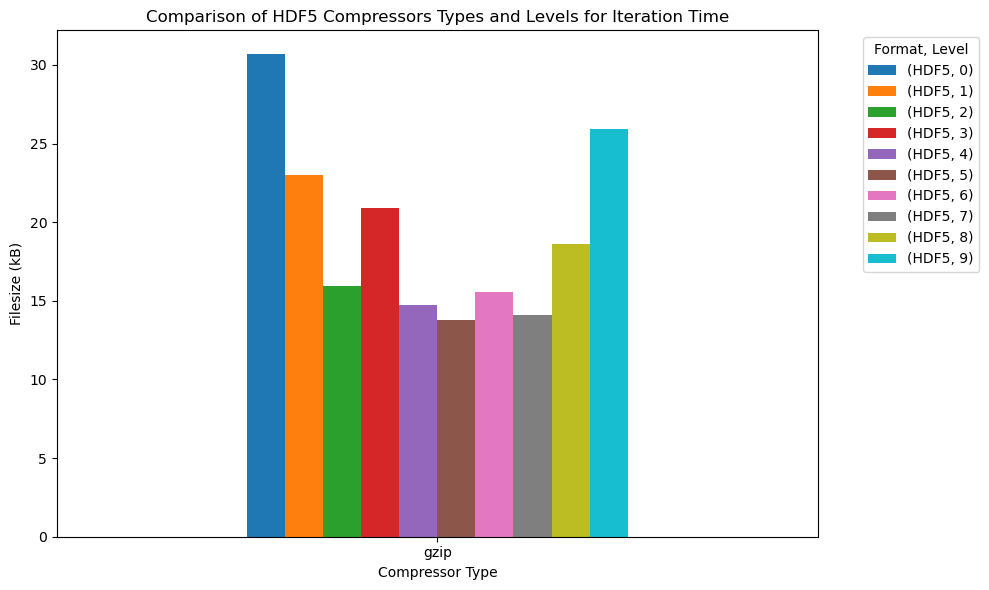

In [37]:
# Plot hdf5 iteration time for each compressor and level

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

format = ['HDF5'] * 10 * len(hdf5_compressors)

compressor = [n for n in hdf5_compressors for _ in range(10)]

lvl = list(range(10)) * len(hdf5_compressors)
val = []

for c in hdf5_compressors:
    for i in range(10):
        val.append(h5_iteration_time(f'h5files/yiip_{c}_{i}_hdf5.h5'))


data = {
    'Format': format,
    'Compressor': compressor,
    'Level': lvl,
    'Filesize': val
}

df = pd.DataFrame(data)

pivot_df = df.pivot(index='Compressor', columns=['Format', 'Level'], values='Filesize')

pivot_df.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of HDF5 Compressors Types and Levels for Iteration Time')
plt.xlabel('Compressor Type')
plt.ylabel('Filesize (kB)')
plt.xticks(rotation=0)
plt.legend(title='Format, Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()